In [69]:
import csv

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

tf.device('/gpu:0')
RANDOM_SEED = 42

# Specify each path

In [70]:
dataset = '../model/keypoint_classifier/keypoint.csv'
model_save_path = '../model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = '../model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [71]:
NUM_CLASSES = 6

# Dataset reading

In [72]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [73]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Xử lý dữ liệu

## THỐNG KÊ VÀ TÌM HIỂU DỮ LIỆU

---

In [75]:
X_dataset_check = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(0, (21 * 2) + 1)))
X_dataset_check = pd.DataFrame(X_dataset_check)
print(X_dataset_check)

        0    1    2         3         4         5         6         7   \
0      0.0  0.0  0.0 -0.122378 -0.108392 -0.227273 -0.307692 -0.171329   
1      0.0  0.0  0.0 -0.125436 -0.097561 -0.233449 -0.292683 -0.177700   
2      0.0  0.0  0.0 -0.122378 -0.101399 -0.227273 -0.293706 -0.174825   
3      0.0  0.0  0.0 -0.125874 -0.090909 -0.230769 -0.283217 -0.178322   
4      0.0  0.0  0.0 -0.125874 -0.087413 -0.237762 -0.283217 -0.181818   
...    ...  ...  ...       ...       ...       ...       ...       ...   
19455  5.0  0.0  0.0 -0.173469 -0.088435 -0.282313 -0.231293 -0.231293   
19456  5.0  0.0  0.0 -0.194346 -0.095406 -0.303887 -0.233216 -0.261484   
19457  5.0  0.0  0.0 -0.195730 -0.092527 -0.306050 -0.227758 -0.259786   
19458  5.0  0.0  0.0 -0.192171 -0.096085 -0.295374 -0.234875 -0.256228   
19459  5.0  0.0  0.0 -0.197842 -0.100719 -0.312950 -0.237410 -0.266187   

             8         9   ...        33        34        35        36  \
0     -0.468531 -0.027972  ... -0.003

In [76]:
X_dataset_check.groupby(0).size()


0
0.0    4697
1.0    3166
2.0    2837
3.0    2931
4.0    3257
5.0    2572
dtype: int64

In [77]:
X_dataset_check.head(15)

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0.0,0.0,0.0,-0.122378,-0.108392,-0.227273,-0.307692,-0.171329,-0.468531,-0.027972,...,-0.003497,-0.272727,0.209790,-0.395105,0.139860,-0.440559,0.073427,-0.318182,0.076923,-0.258741
1,0.0,0.0,0.0,-0.125436,-0.097561,-0.233449,-0.292683,-0.177700,-0.456446,-0.038328,...,-0.013937,-0.264808,0.205575,-0.397213,0.132404,-0.428571,0.066202,-0.303136,0.073171,-0.250871
2,0.0,0.0,0.0,-0.122378,-0.101399,-0.227273,-0.293706,-0.174825,-0.454545,-0.038462,...,-0.010490,-0.269231,0.206294,-0.395105,0.139860,-0.437063,0.076923,-0.311189,0.076923,-0.258741
3,0.0,0.0,0.0,-0.125874,-0.090909,-0.230769,-0.283217,-0.178322,-0.447552,-0.041958,...,-0.006993,-0.258741,0.209790,-0.391608,0.129371,-0.426573,0.069930,-0.297203,0.076923,-0.248252
4,0.0,0.0,0.0,-0.125874,-0.087413,-0.237762,-0.283217,-0.181818,-0.447552,-0.038462,...,-0.013986,-0.255245,0.199301,-0.395105,0.132867,-0.419580,0.069930,-0.297203,0.069930,-0.244755
5,0.0,0.0,0.0,-0.122807,-0.091228,-0.228070,-0.284211,-0.171930,-0.445614,-0.035088,...,-0.007018,-0.263158,0.210526,-0.389474,0.143860,-0.421053,0.077193,-0.294737,0.080702,-0.249123
6,0.0,0.0,0.0,-0.119718,-0.095070,-0.221831,-0.285211,-0.172535,-0.440141,-0.038732,...,-0.003521,-0.253521,0.218310,-0.383803,0.147887,-0.426056,0.080986,-0.299296,0.084507,-0.242958
7,0.0,0.0,0.0,-0.127208,-0.081272,-0.236749,-0.279152,-0.183746,-0.445230,-0.045936,...,-0.014134,-0.257951,0.208481,-0.392226,0.134276,-0.427562,0.070671,-0.296820,0.077739,-0.247350
8,0.0,0.0,0.0,-0.130282,-0.084507,-0.239437,-0.278169,-0.183099,-0.447183,-0.042254,...,-0.017606,-0.253521,0.204225,-0.387324,0.133803,-0.426056,0.066901,-0.299296,0.066901,-0.242958
9,0.0,0.0,0.0,-0.126761,-0.084507,-0.235915,-0.274648,-0.183099,-0.436620,-0.049296,...,-0.014085,-0.253521,0.204225,-0.380282,0.140845,-0.426056,0.073944,-0.295775,0.073944,-0.242958


In [78]:
# In thông tin các cột trong DF => không tồn tại kiểu dự liệu phi số, không sữ liệu rỗng, dữ liệu đã được tiền xử lý
X_dataset_check.info()
print('Shape tập dữ liệu: ', X_dataset_check.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19460 entries, 0 to 19459
Data columns (total 43 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       19460 non-null  float32
 1   1       19460 non-null  float32
 2   2       19460 non-null  float32
 3   3       19460 non-null  float32
 4   4       19460 non-null  float32
 5   5       19460 non-null  float32
 6   6       19460 non-null  float32
 7   7       19460 non-null  float32
 8   8       19460 non-null  float32
 9   9       19460 non-null  float32
 10  10      19460 non-null  float32
 11  11      19460 non-null  float32
 12  12      19460 non-null  float32
 13  13      19460 non-null  float32
 14  14      19460 non-null  float32
 15  15      19460 non-null  float32
 16  16      19460 non-null  float32
 17  17      19460 non-null  float32
 18  18      19460 non-null  float32
 19  19      19460 non-null  float32
 20  20      19460 non-null  float32
 21  21      19460 non-null  float32
 22

## Check số lượng các nhãn
---

          Nhãn  Quy đổi
0      Nothing      0.0
1      Nothing      0.0
2      Nothing      0.0
3      Nothing      0.0
4      Nothing      0.0
...        ...      ...
19455    Click      5.0
19456    Click      5.0
19457    Click      5.0
19458    Click      5.0
19459    Click      5.0

[19460 rows x 2 columns]


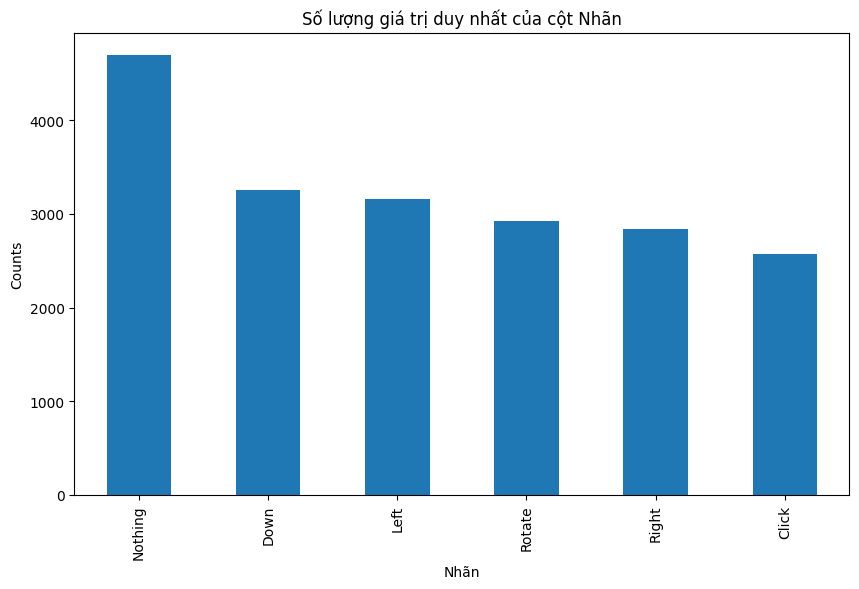

-----------------------------------------------
Số các giá trị duy nhất của cột Nhãn:
Nhãn
Nothing    4697
Down       3257
Left       3166
Rotate     2931
Right      2837
Click      2572
Name: count, dtype: int64


In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

def categories_counts(label_name, dataset):
    print(f'-----------------------------------------------')
    print(f'Số các giá trị duy nhất của cột {label_name}:')
    print(dataset[label_name].value_counts())
    
def plt_categories_counts(label_name, dataset):
    counts = dataset[label_name].value_counts()
    plt.figure(figsize=(10, 6))
    counts.plot(kind='bar')
    plt.title(f'Số lượng giá trị duy nhất của cột {label_name}')
    plt.xlabel(label_name)
    plt.ylabel('Counts')
    plt.show()
    categories_counts(label_name, dataset)

label = X_dataset_check[0]
label = pd.DataFrame(label)

a = len(label)
new_column = [None] * len(label)
new_column = pd.DataFrame(new_column)
label = pd.concat([new_column,label],axis=1)
label.columns = ['Nhãn', 'Quy đổi']

label.loc[label['Quy đổi'] == 0, 'Nhãn'] = 'Nothing'
label.loc[label['Quy đổi'] == 1, 'Nhãn'] = 'Left'
label.loc[label['Quy đổi'] == 2, 'Nhãn'] = 'Right'
label.loc[label['Quy đổi'] == 3, 'Nhãn'] = 'Rotate'
label.loc[label['Quy đổi'] == 4, 'Nhãn'] = 'Down'
label.loc[label['Quy đổi'] == 5, 'Nhãn'] = 'Click'

print(label)

# Đếm các giá trị duy nhất của các cột có Nhãn 
plt_categories_counts('Nhãn', label)


## Kiểm tra mức độ sạch của dữ liệu
---

In [110]:
def statistical_missing_data(dataFrame):
    missing_data = dataFrame.isnull().sum()
    duplicate_data = dataFrame.duplicated().sum()

    print("Số liệu thiếu trong mỗi cột:")
    print(missing_data)
    print("\nSố liệu trùng lặp:")
    print(duplicate_data)

# Thống kê dữ liệu khuyết
statistical_missing_data(X_dataset_check)
print(X_dataset_check)

Số liệu thiếu trong mỗi cột:
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
dtype: int64

Số liệu trùng lặp:
0
        0    1    2         3         4         5         6         7   \
0      0.0  0.0  0.0 -0.122378 -0.108392 -0.227273 -0.307692 -0.171329   
1      0.0  0.0  0.0 -0.125436 -0.097561 -0.233449 -0.292683 -0.177700   
2      0.0  0.0  0.0 -0.122378 -0.101399 -0.227273 -0.293706 -0.174825   
3      0.0  0.0  0.0 -0.125874 -0.090909 -0.230769 -0.283217 -0.178322   
4      0.0  0.0  0.0 -0.125874 -0.087413 -0.237762 -0.283217 -0.181818   
...    ...  ...  ...       ...       ...       ...       ...       ...   
19455  5.0  0.0  0.0 -0.173469 -0.088435 -0.282313 -0.231293 -0.231293   


In [114]:
def plt_statistics_missing_data(dataFrame):
    # Dữ liệu khuyết
    missing_data = dataFrame.isnull().sum()
    missing_data = missing_data[missing_data > 0]
    plt.figure(figsize=(10, 5))
    missing_data.plot(kind='bar')
    plt.title('Dữ liệu khuyết trong mỗi cột')
    plt.xlabel('Tên cột')
    plt.ylabel('Số lượng dữ liệu khuyết')
    plt.show()

    # Dữ liệu lặp
    duplicate_data = dataFrame.duplicated().sum()
    print("\nSố liệu trùng lặp:", duplicate_data)

# Thống kê dữ liệu khuyết
# plt_statistics_missing_data(X_dataset_check)
missing_data = X_dataset_check.isnull().sum()
print(missing_data)


0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
dtype: int64


In [115]:
X_dataset_check.describe()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
count,19460.000000,19460.0,19460.0,19460.000000,19460.000000,19460.000000,19460.000000,19460.000000,19460.000000,19460.000000,...,19460.000000,19460.000000,19460.000000,19460.000000,19460.000000,19460.000000,19460.000000,19460.000000,19460.000000,19460.000000
mean,2.236434,0.0,0.0,-0.012076,-0.099397,-0.020639,-0.285771,-0.029278,-0.452333,-0.041685,...,-0.016606,-0.496844,-0.001876,-0.493643,-0.004141,-0.619261,-0.004968,-0.604843,-0.006857,-0.625836
std,1.755563,0.0,0.0,0.222880,0.110593,0.409742,0.197811,0.503376,0.257774,0.522679,...,0.238591,0.295095,0.244500,0.203286,0.289082,0.248443,0.283683,0.263821,0.284241,0.312921
min,0.000000,0.0,0.0,-0.505747,-0.561404,-0.873563,-0.938596,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-0.893443,-1.000000,-1.000000,-1.000000,-0.937500,-1.000000,-1.000000,-1.000000
25%,1.000000,0.0,0.0,-0.198238,-0.158280,-0.338552,-0.379085,-0.397968,-0.567308,-0.402316,...,-0.159262,-0.637168,-0.169704,-0.586207,-0.175676,-0.754505,-0.166667,-0.806113,-0.160049,-0.907095
50%,2.000000,0.0,0.0,-0.087146,-0.107143,-0.107205,-0.309623,-0.074451,-0.481227,-0.029851,...,-0.019455,-0.432710,-0.028986,-0.505102,-0.026966,-0.675676,-0.024610,-0.669065,-0.024793,-0.635388
75%,4.000000,0.0,0.0,0.183358,-0.046632,0.302244,-0.224138,0.353196,-0.390608,0.340793,...,0.106599,-0.306818,0.157743,-0.412207,0.156603,-0.512474,0.142518,-0.469292,0.130812,-0.414738
max,5.000000,0.0,0.0,0.530120,0.472727,0.907895,0.828829,1.000000,1.000000,1.000000,...,1.000000,0.728814,1.000000,0.569767,1.000000,0.827586,1.000000,0.803571,1.000000,0.952381


In [118]:
# find the correlation among the columns in the Dataframe
X_dataset_check.corr()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,1.000000,NaN,NaN,0.006853,-0.002633,0.023348,-0.082492,0.035213,-0.159960,0.045039,...,-0.018452,-0.110735,-0.011557,-0.319398,-0.022003,-0.402378,-0.023207,-0.465150,-0.009927,-0.461815
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.006853,NaN,NaN,1.000000,0.025315,0.984659,-0.019335,0.955606,-0.052436,0.898175,...,0.304989,-0.028473,-0.382752,-0.054237,-0.155347,-0.106623,-0.131220,-0.125234,-0.152875,-0.125480
4,-0.002633,NaN,NaN,0.025315,1.000000,0.001746,0.935346,-0.017716,0.825050,-0.036000,...,-0.061677,0.337471,-0.112401,-0.078121,-0.070497,0.009118,-0.060268,0.067934,-0.076240,0.054864
5,0.023348,NaN,NaN,0.984659,0.001746,1.000000,-0.043611,0.987558,-0.077067,0.938495,...,0.385744,-0.037148,-0.265855,-0.040326,-0.055231,-0.097837,-0.041632,-0.122583,-0.061419,-0.123987
6,-0.082492,NaN,NaN,-0.019335,0.935346,-0.043611,1.000000,-0.055620,0.964480,-0.060659,...,-0.076285,0.371218,-0.088528,0.168741,-0.067060,0.248655,-0.060280,0.217475,-0.074204,0.157978
7,0.035213,NaN,NaN,0.955606,-0.017716,0.987558,-0.055620,1.000000,-0.084547,0.977964,...,0.430838,-0.039631,-0.186269,-0.022629,0.020254,-0.086217,0.026433,-0.123467,0.005033,-0.127556
8,-0.159960,NaN,NaN,-0.052436,0.825050,-0.077067,0.964480,-0.084547,1.000000,-0.082775,...,-0.078651,0.365042,-0.062761,0.320819,-0.049833,0.398650,-0.045439,0.316303,-0.059595,0.228904
9,0.045039,NaN,NaN,0.898175,-0.036000,0.938495,-0.060659,0.977964,-0.082775,1.000000,...,0.441986,-0.038435,-0.120441,-0.001712,0.077465,-0.068187,0.077253,-0.118206,0.053907,-0.125658


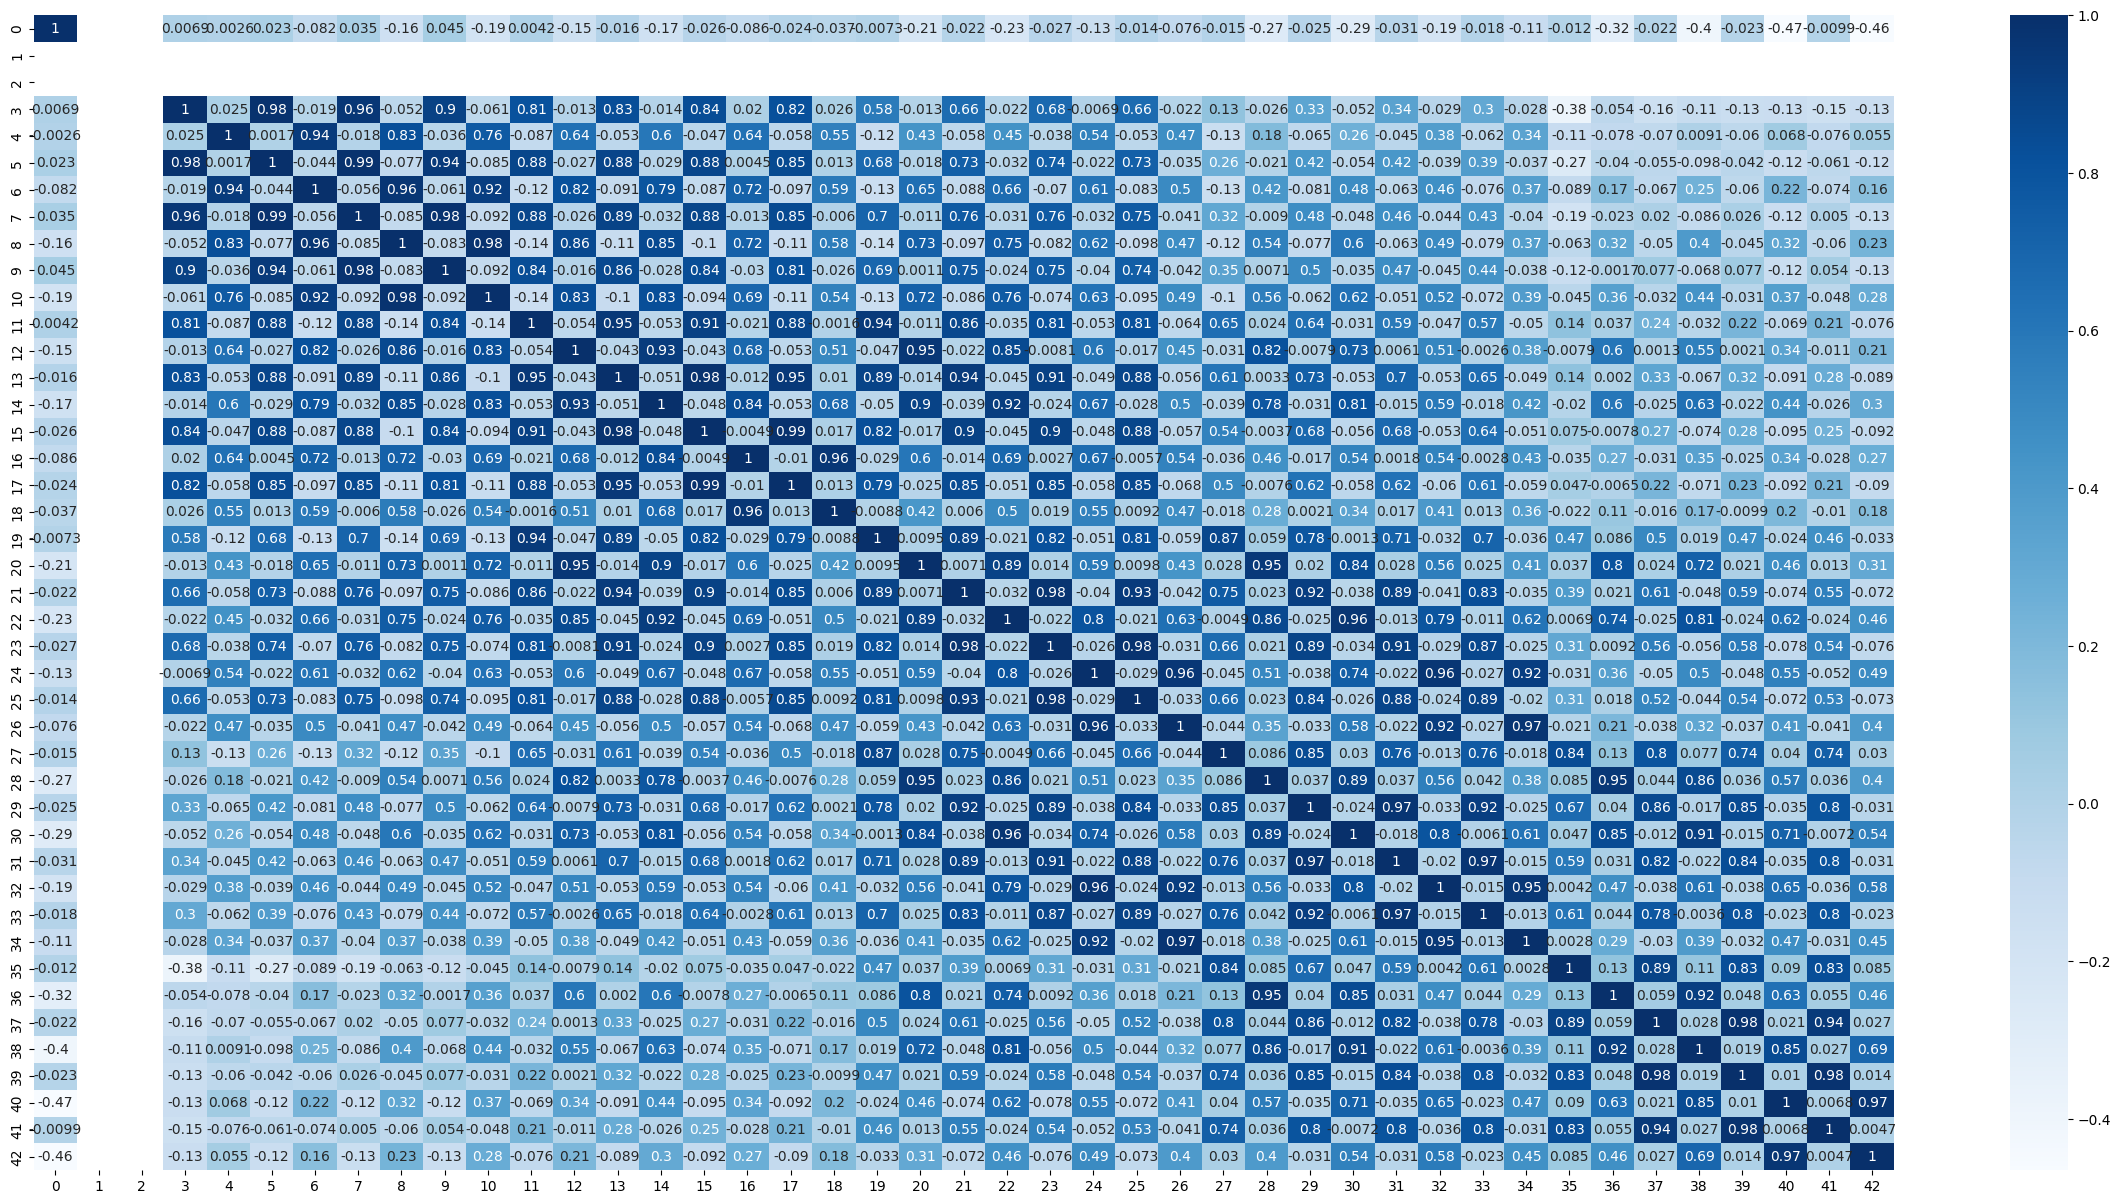

In [124]:
plt.figure(figsize = (30,15))
sns.heatmap(X_dataset_check.corr(numeric_only = True), annot = True, cmap = plt.cm.Blues)
plt.show()

# Model building

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [ ]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 6)                 66        
                                                                 
Total params: 1,136
Trainable params: 1,136
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False) # automatically save your model
# verbose : gọi lại thông báo mỗi khi thông báo
# save_weights_only: lưu lại cả mô hình lẫn thông số mô hình nếu False

# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)
# dừng quá trình đào tạo nếu hiệu suất mô hình ko đc cải thiện

In [ ]:
# Model compilation
model.compile(
    optimizer='adam', # hàm tối ưu
    loss='sparse_categorical_crossentropy', # hàm mất mát
    metrics=['accuracy'] # thuước  đo đánh giá
)

# Model training

In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
114/115 [============================>.] - ETA: 0s - loss: 1.7478 - accuracy: 0.2621
Epoch 1: saving model to ../model/keypoint_classifier\keypoint_classifier.hdf5
115/115 [==============================] - 9s 61ms/step - loss: 1.7477 - accuracy: 0.2621 - val_loss: 1.6556 - val_accuracy: 0.4327
Epoch 2/1000
110/115 [===========================>..] - ETA: 0s - loss: 1.6484 - accuracy: 0.3352
Epoch 2: saving model to ../model/keypoint_classifier\keypoint_classifier.hdf5
115/115 [==============================] - 5s 41ms/step - loss: 1.6458 - accuracy: 0.3370 - val_loss: 1.4661 - val_accuracy: 0.5424
Epoch 3/1000
113/115 [============================>.] - ETA: 0s - loss: 1.5086 - accuracy: 0.3972
Epoch 3: saving model to ../model/keypoint_classifier\keypoint_classifier.hdf5
115/115 [==============================] - 5s 43ms/step - loss: 1.5087 - accuracy: 0.3971 - val_loss: 1.2389 - val_accuracy: 0.6434
Epoch 4/1000
112/115 [============================>.] - ETA: 0s - loss: 1

In [ ]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

39/39 [==============================] - 0s 9ms/step - loss: 0.6068 - accuracy: 0.8407


In [ ]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [ ]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 391ms/step
[0.03697964 0.3389908  0.2730419  0.02341757 0.29147017 0.03609989]
1


# Draw Loss and Accuracy

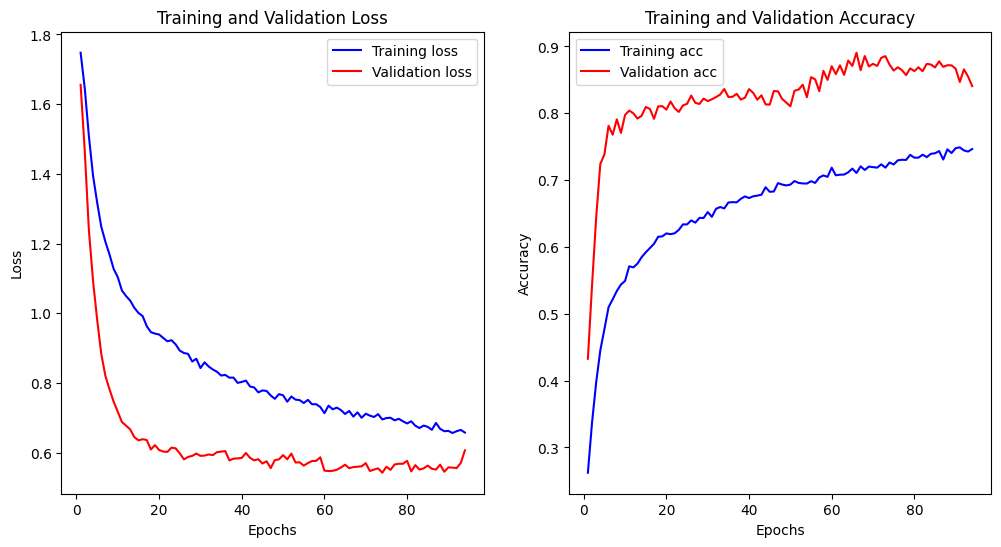

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Lấy thông tin về loss và accuracy từ history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)

    # Vẽ biểu đồ Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Vẽ biểu đồ Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_training_history(history)

# Confusion matrix

153/153 [==============================] - 0s 3ms/step


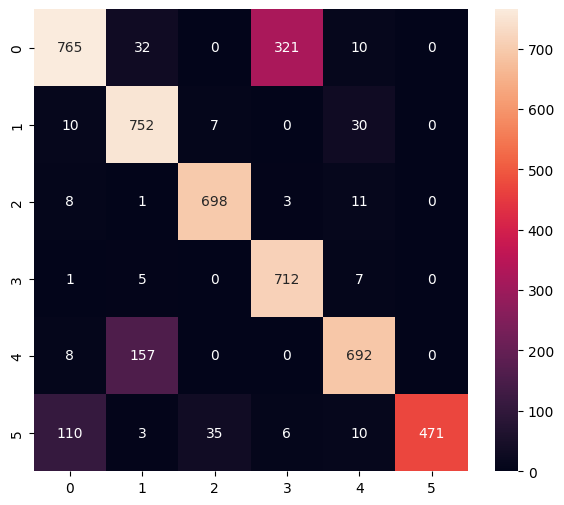

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.68      0.75      1128
           1       0.79      0.94      0.86       799
           2       0.94      0.97      0.96       721
           3       0.68      0.98      0.81       725
           4       0.91      0.81      0.86       857
           5       1.00      0.74      0.85       635

    accuracy                           0.84      4865
   macro avg       0.86      0.85      0.85      4865
weighted avg       0.86      0.84      0.84      4865



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [ ]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [ ]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ADMIN\AppData\Local\Temp\tmpknnmnxph\assets


6632

# Inference test

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [ ]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 42]), 'shape_signature': array([-1, 42]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [ ]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.03697965 0.3389908  0.27304196 0.02341758 0.2914702  0.0360999 ]
1
